# Проектная работа. Разработка скважин "ГлавРосГосНефть"

Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# 1. Загрузка и подготовка данных

In [3]:
# грузим данные
try:
    geo_data_0 = pd.read_csv("G:/Projects/praktikum/datasets/geo_data_0.csv")
    geo_data_1 = pd.read_csv("G:/Projects/praktikum/datasets/geo_data_1.csv")
    geo_data_2 = pd.read_csv("G:/Projects/praktikum/datasets/geo_data_2.csv")
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Описание данных:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

In [4]:
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


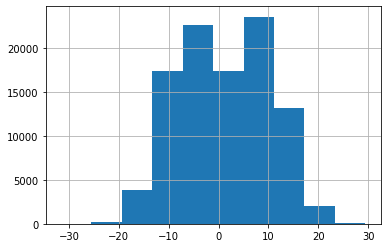

In [6]:
geo_data_1['f0'].hist()

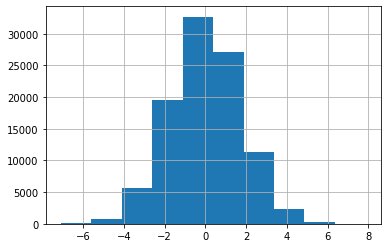

In [7]:
geo_data_2['f1'].hist()

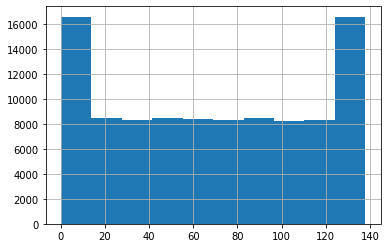

In [8]:
geo_data_1['product'].hist()

Данные выглядят вроде нормально. Они же синтетические:)

Для обучения моделей будем использовать следующие данные:
* Столбец 'id' нам бесполезен
* Значимые признаки - f0, f1, f2
* Целевой признак - product

## 2. Обучите и проверьте модель для каждого региона

In [9]:
# так как нам всё придётся делать по три раза - для каждого региона, будем писать функции, дабы не копипастить много
def data_prep(data):
    train_data, valid_data = train_test_split(data, test_size=0.25, random_state=112211)
    
    features_train = train_data.drop(['id', 'product'], axis=1)
    target_train = train_data['product']
    features_valid = valid_data.drop(['id', 'product'], axis=1)
    target_valid = valid_data['product']
    
    return features_train, target_train, features_valid, target_valid

In [10]:
# признаки региона 0
features_train_0, target_train_0, features_valid_0, target_valid_0 = data_prep(geo_data_0)

# признаки региона 1
features_train_1, target_train_1, features_valid_1, target_valid_1 = data_prep(geo_data_1)

# признаки региона 2
features_train_2, target_train_2, features_valid_2, target_valid_2 = data_prep(geo_data_2)

In [11]:
features_train_1.shape

(75000, 3)

In [12]:
target_valid_2.shape

(25000,)

Данные готовы. Переходим к обучению.

По условиям задачи, необходимо использовать модель линейной регрессии. 

In [14]:
# напишем функцию, которая посчитает и выведет все необходимые данные
def modeling(features_train, target_train, features_valid, target_valid):
    
    # масштабируем признаки
    scaler = StandardScaler()
    scaler.fit(features_train)
    features = scaler.transform(features_train)
    features_val = scaler.transform(features_valid)
    
    # обучаем модель
    model = LinearRegression()
    model.fit(features, target_train)
    
    predictions = model.predict(features_val)
    mse = mean_squared_error(target_valid, predictions)
    
    print('Модель обучена.')
    print('RMSE =', mse**0.5)
    print('Среднее предсказанных значений:', predictions.mean())
    print('Реальное среднее целевой выборки:', target_valid.mean())
    
    return predictions

In [15]:
# результат предсказаний запишем в Series, чтобы дальше работать с ним
# регион 0
predict_0 = pd.Series(modeling(features_train_0, target_train_0, features_valid_0, target_valid_0))

Модель обучена.
RMSE = 37.78234566843369
Среднее предсказанных значений: 92.51080087291714
Реальное среднее целевой выборки: 92.5614297041345


In [16]:
# регион 1
predict_1 = pd.Series(modeling(features_train_1, target_train_1, features_valid_1, target_valid_1))

Модель обучена.
RMSE = 0.8903037843908675
Среднее предсказанных значений: 68.70883673619505
Реальное среднее целевой выборки: 68.7042383328306


In [17]:
# регион 2
predict_2 = pd.Series(modeling(features_train_2, target_train_2, features_valid_2, target_valid_2))

Модель обучена.
RMSE = 40.19050851718416
Среднее предсказанных значений: 94.87525290339977
Реальное среднее целевой выборки: 95.3228608252354


### Выводы

Были обучены модели линейной регрессии для каждого региона. Определены RMSE, и найдены средние значения целевых признаков(объемы скважин).

Для региона 1 модель показала подозрительно низкие значения и большую ошибку. Средний запас ресурсов в этом регионе так же ниже, чем в регионе 0 и 2.

Показатели моделей и среднее по регионам 0 и 2 близки по значениям.

## 3. Подготовьтесь к расчёту прибыли

In [18]:
# выносим константы
# кол-во точек для бурения
MAX_POINT = 200

# стоимость за тыс баррелей
BAR_1K_PRICE = 0.45

# бюджет на регион (млн.р)
BUDGET= 10000

In [19]:
# минимальная добыча сырья с одной точки для безубыточной работы
min_1k_barrels_need = (BUDGET / MAX_POINT) / BAR_1K_PRICE
min_1k_barrels_need

111.11111111111111

### Выводы
Для того, чтобы уложиться в бюджет, необходимо с каждой скважины добывать не менее 111 тыс. баррелей!
В регионах у нас были следующие средние:
Регион 0 - 92 тыс. бар.
Регион 1 - 68 тыс. бар.
Регион 2 - 95 тыс. бар.

Похоже, что у региона 1 не много шансов быть избранным. А вот у регионов 0 и 2 шансы неплохие. Только к выбору мест бурения надо подойти ответственно.

## 4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [20]:
# функция берёт топ скважин по предсказанной добыче и суммирует добычу по ним и прибыль
def profit_account(predict, target):
    top_points = predict.sort_values(ascending=False)[:MAX_POINT]
    target_points = target.iloc[top_points.index]
        
    bar_prod = target_points.sum()
    max_margin = (bar_prod*BAR_1K_PRICE) - BUDGET
    return max_margin

In [24]:
# для региона 0
print('Максимальная прибыль региона:', profit_account(predict_0, target_valid_0), 'млн.р')

Максимальная прибыль региона: 3300.661243225102 млн.р


In [26]:
# для региона 1
print('Максимальная прибыль региона:', profit_account(predict_1, target_valid_1), 'млн.р')

Максимальная прибыль региона: 2415.086696681512 млн.р


In [25]:
# для региона 2
print('Максимальная прибыль региона:', profit_account(predict_2, target_valid_2), 'млн.р')

Максимальная прибыль региона: 2618.20084180495 млн.р


### Выводы
Получили предсказанную максимальную прибыль для 200 лучших скважин каждого региона:
* Регион 0 - 3.3 млрд. р.
* Регион 1 - 2.4 млрд. р.
* Регион 2 - 2.6 млрд. р.

Ну что ж, в принципе, у всех регионов есть шансы быть избранными. Но посмотрим на риски.

## 5. Посчитайте риски и прибыль для каждого региона

Для рассчёта рисков мы будем использовать технику BootStrap следующим образом:
1. Берём сэмпл из 500 случайных предсказанных размеров залежей в регионе(по условиям задачи исследуют 500 скважин)
2. Из этих 500 выбираем 200 с наивысшими предсказаниями. 
3. Для этого применим функцию из раздела 4, которая посчитает и вернёт прибыль.
4. Так повторяем 1000 раз.
5. Profit!

Доверительный интервал 95% оценим через квантили полученных возможных прибылей.
Риск убытков равен доле сэмплов(х/1000), в которых рассчитанная прибыль оказалась меньше бюджета на регион (10 млрд.р.)

In [37]:
state = np.random.RandomState(112211)

# пишем функцию
def risk_margin_bootstr(predict, target):
    margin_means = []
    
    # bootstrap
    for i in range(1000):
        sample = predict.sample(n=500, replace=True, random_state=state)
        
        # функция из раздела 4 для расчёта дохода
        margin = profit_account(sample, target)
        margin_means.append(margin)
    
    # доверительный интервал 0.95
    margin_means = pd.Series(margin_means)
    confidence_interval = [margin_means.quantile(0.025), margin_means.quantile(0.975)]
    
    # считаем риск. Кол-во обнаруженных непрофитных выборок
    risk = (margin_means[margin_means<0].count())*100/1000   
    
    # выведем все данные на экран
    print('Среднее значение прибыли для региона:', margin_means.mean())
    print('Дисперсия:', np.var(margin_means))
    print('95% доверительный интервал прибыли:', confidence_interval)
    print('Риск убытков: {}%'.format(risk))
    
    #построим гистограмму средних п
    plt.figure(figsize=(10,5))
    margin_means.plot(kind='hist', bins=35)
    plt.plot([0,0], [0,100], linestyle='--')
    plt.xlabel('Margin')
    plt.title('BootStrap sample margin dist mln.rub.')
    plt.show()

Среднее значение прибыли для региона: 414.48399665251117
Дисперсия: 71483.63548199953
95% доверительный интервал прибыли: [-130.40326883243645, 932.2320873710206]
Риск убытков: 5.4%


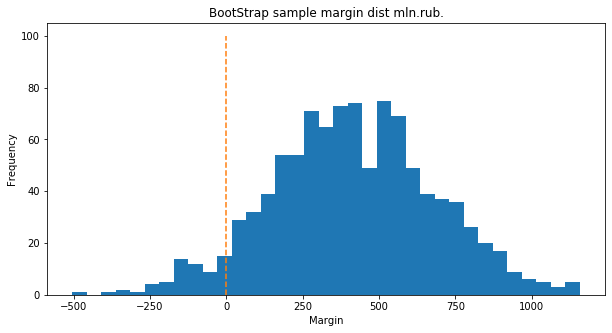

In [38]:
# регион 0
risk_margin_bootstr(predict_0, target_valid_0)

Среднее значение прибыли для региона: 443.1759603079867
Дисперсия: 39620.035727421986
95% доверительный интервал прибыли: [41.71833321316908, 828.7888019062476]
Риск убытков: 1.7999999999999998%


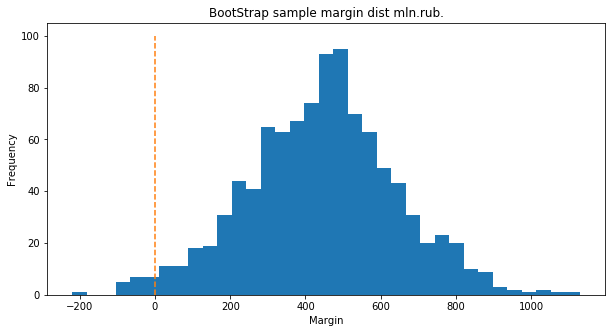

In [33]:
# регион 1
risk_margin_bootstr(predict_1, target_valid_1)

Среднее значение прибыли для региона: 416.84890515564535
Дисперсия: 69262.05067687397
95% доверительный интервал прибыли: [-80.0539367615761, 936.7958709875671]
Риск убытков: 5.6000000000000005%


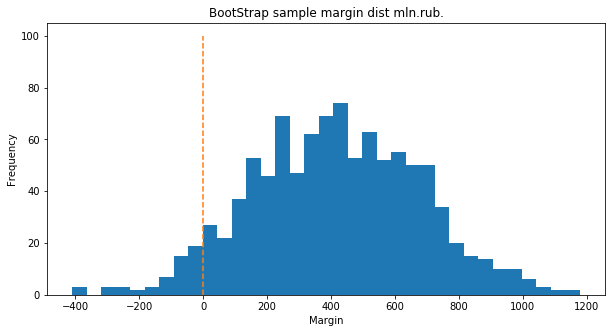

In [34]:
# регион 2
risk_margin_bootstr(predict_2, target_valid_2)

### Выводы
Интересные получились результаты!

Средние прибылей и доверительные интервалы для всех трёх регионов примерно равны. Но вот с точки зрения рисков, они в регионах 0 и 2 существенно выше, чем для региона 1.

По условию задачи, регионы с риском больше 2.5% не принимаются. Таким образом, соответствующий всем критериям остаётся только регион 1 (риск убытков - 1.8%). 

## 6. Выводы
Целью работы было изучение данных о залежах ископаемых в трёх регионах, и выбор наиболее перспективного региона для разработки с точки зрения возможной прибыли и рисков.

Входными данным были данные геологоразведки трёх регионов: регион 0, регион 1 и регион 2.

Данные были загружены, проанализированы и подготовлены для дальнейшего изучения - были выбраны признаки для обучения модели, целевой признак. Также данные были разбиты на обучающую и валидационную выборки.

Для каждого региона были обучены модели линейной регрессии, проведена валидация, посчитаны и проанализированы полученные метрики.

Далее были проанализированы параметры возможной прибыли для каждого региона. На основании предсказаний модели были посчитаны максимально возможная добыча и прибыль для регионов.
* Регион 0 - 3.3 млрд. р.
* Регион 1 - 2.4 млрд. р.
* Регион 2 - 2.6 млрд. р.

Техникой BootStrap были проанализированы возможные риски и прибыльность разработки регионов. По условиям, выбирались 200 месторождений с максимальным запасом, и оценивалась возможная прибыль. 
Оценен 95% доверительный интервал этого значения для каждого региона.
Так же условием является минимальная общая прибыль в 10 000 млн. рублей с региона, при цене барреля 450 р. Для оценки рисков, оценивалась доля возможных выборок месторождений, суммарная прибыль которых будет меньше необходимых 10 млрд. р.

Результаты:
##### Регион 0
* Средняя прибыль региона: 413.48 млн. р.
* Риск убытков: 5.4 %

##### Регион 1
* Средняя прибыль региона: 443.18 млн. р.
* Риск убытков: 1.8 %

##### Регион 2
* Средняя прибыль региона: 416.85 млн. р.
* Риск убытков: 5.6 %

*Максимально допусимый уровень риска 2.5 %. 

Таким образом, всем критериям соотвествует только регион 1. Именно его и можно рекомендовать для разработки.